# **LAB 1: DỰ ĐOÁN GIÁ XE**

# Giới thiệu nhóm

## Nhóm 14:
1. Lê Thái Ngọc
2. Nguyễn Ngọc Khoa (23122036)


# Mục tiêu của Bài tập

Mục đích của notebook này là triển khai các mô hình hồi quy để dự đoán giá xe dựa trên dữ liệu từ các cột đặc trưng khác nhau. Một cách tổng quan, trong notebook sẽ có các công việc lớn như sau:
- Phân tích và tiền xử lý dữ liệu.
- Lựa chọn đặc trưng quan trọng.
- Áp dụng các mô hình hồi quy khác nhau.
- Đánh giá và so sánh hiệu năng của các mô hình.
- Đánh giá trên tập test

# Các khởi tạo ban đầu

## Các thư viện sử dụng

In [1]:
# Các thư viện để xử lí số học và data
import pandas as pd
import numpy as np
# Các thư viện để visualize
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns
# Các thư viện khác
import re
from typing import List
from collections import defaultdict

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Các hàm loss

In [3]:
# loss functions
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)

    if ss_total == 0:
        return 0
    return 1 - (ss_residual / ss_total)

# get all above metrics results
def calculate_losses(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

## Các hàm visualization

In [4]:
def plot_data_overview(df, numeric_columns, target='Price'):
    plt.figure(figsize=(20, 15))
    plt.suptitle('Data Overview', fontsize=20, y=0.95)

    plt.subplot(2, 3, 1)
    sns.histplot(df[target], kde=True)
    plt.title(f'Distribution of {target}')
    plt.xlabel(target)
    plt.ylabel('Frequency')

    plt.subplot(2, 3, 2)
    sns.histplot(np.log1p(df[target]), kde=True)
    plt.title(f'Log Distribution of {target}')
    plt.xlabel(f'Log({target})')
    plt.ylabel('Frequency')

    if 'Year' in df.columns:
        plt.subplot(2, 3, 3)
        sns.countplot(y=df['Year'].astype(str))
        plt.title('Cars by Year')
        plt.xlabel('Count')
        plt.ylabel('Year')

    if 'Make' in df.columns:
        plt.subplot(2, 3, 4)
        top_makes = df['Make'].value_counts().nlargest(10).index
        sns.countplot(y=df[df['Make'].isin(top_makes)]['Make'], order=df['Make'].value_counts().nlargest(10).index)
        plt.title('Top 10 Car Makes')
        plt.xlabel('Count')
        plt.ylabel('Make')

    if 'Kilometer' in df.columns:
        plt.subplot(2, 3, 5)
        sns.scatterplot(x='Kilometer', y=target, data=df, alpha=0.3)
        plt.title(f'{target} vs Kilometer')
        plt.xlabel('Kilometer')
        plt.ylabel(target)

    plt.subplot(2, 3, 6)
    missing = df.isnull().sum().sort_values(ascending=False)
    missing = missing[missing > 0]
    if not missing.empty:
        missing.plot(kind='bar')
        plt.title('Missing Values by Column')
        plt.xlabel('Column')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No missing values', horizontalalignment='center', verticalalignment='center')
        plt.title('Missing Values Check')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def plot_correlation_matrix(df, numeric_columns, figsize=(12, 10)):
    correlation_matrix = df[numeric_columns].corr()

    cmap = LinearSegmentedColormap.from_list('blue_white_red', ['#1E88E5', 'white', '#E53935'])

    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1,
                annot=True, fmt='.2f', linewidths=0.5, square=True, cbar_kws={'shrink': .8})

    plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

def plot_model_comparison(cv_results):
    models = list(cv_results.keys())
    r2_scores = [cv_results[model]['avg_r2'] for model in models]
    mse_scores = [cv_results[model]['avg_mse'] for model in models]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(x=models, y=r2_scores, ax=ax1, palette='Blues_d')
    ax1.set_title('Model Comparison - R² Score', fontsize=14)
    ax1.set_ylim(0.5, 1)
    ax1.set_xlabel('Model')
    ax1.set_ylabel('R² Score (higher is better)')

    for i, v in enumerate(r2_scores):
        ax1.text(i, v + 0.02, f"{v:.3f}", ha='center')

    sns.barplot(x=models, y=mse_scores, ax=ax2, palette='Reds_d')
    ax2.set_title('Model Comparison - MSE', fontsize=14)
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Mean Squared Error (lower is better)')

    for i, v in enumerate(mse_scores):
        ax2.text(i, v + max(mse_scores)*0.02, f"{v:.2f}", ha='center')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))

    for model in models:
        plt.plot(range(1, len(cv_results[model]['all_r2'])+1),
                cv_results[model]['all_r2'],
                marker='o', label=model)

    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xlabel('Fold')
    plt.ylabel('R² Score')
    plt.title('Cross-Validation Stability (R² Score)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.7, 1.0)
    plt.tight_layout()
    plt.show()

def plot_prediction_analysis(y_true, y_pred, model_name="Best Model"):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    residuals = y_true - y_pred

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Prediction Analysis - {model_name}', fontsize=16, y=0.98)

    ax1.scatter(y_true, y_pred, alpha=0.5, color='royalblue')

    max_val = max(np.max(y_true), np.max(y_pred))
    min_val = min(np.min(y_true), np.min(y_pred))
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--')

    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Predictions vs Actual')

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    ax1.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.2f}',
            transform=ax1.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax2.scatter(y_pred, residuals, alpha=0.5, color='darkgreen')
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals vs Predicted Values')

    sns.histplot(residuals, kde=True, ax=ax3, color='darkorange')
    ax3.axvline(x=0, color='r', linestyle='--')
    ax3.set_xlabel('Residual Value')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Residuals Distribution')

    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    ax3.text(0.05, 0.95, f'Mean = {mean_residual:.2f}\nStd Dev = {std_residual:.2f}',
            transform=ax3.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Tổng quan về Dữ liệu

Trong phần này, chúng ta sẽ tải về và phân tích dữ liệu chứa thông tin về các xe đã qua sử dụng.  

**Các cột dữ liệu chính:**
- **Biến mục tiêu:**
  - **Price:** Giá xe cần dự đoán.
- **Đặc trưng số:**
  - **Year, Kilometer, Fuel Tank Capacity, Length, Width, Height, Seating Capacity**
- **Đặc trưng phân loại:**
  - **Make, Model, Fuel Type, Transmission, Location, Color, Owner, Seller Type, Drivetrain**
- **Trích xuất giá trị số từ các cột văn bản:**
  - **Engine → Engine_cc**
  - **Max Power → Power_bhp**
  - **Max Torque → Torque_Nm**

## Load và Khởi tạo Dữ liệu

In [5]:
# Đọc dữ liệu từ file train.csv
try:
  train_data = pd.read_csv('data/train.csv')
  print("Load dữ liệu từ file train.csv thành công")
except FileNotFoundError:
  print("File train.csv không tồn tại")

Load dữ liệu từ file train.csv thành công


In [6]:
# In ra số dòng và tên các cột
print(f"Số dòng trong tập dữ liệu: {train_data.shape[0]}")
print(f"Tên các cột trong tập dữ liệu: {train_data.columns.tolist()}")

Số dòng trong tập dữ liệu: 1647
Tên các cột trong tập dữ liệu: ['Make', 'Model', 'Price', 'Year', 'Kilometer', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Engine', 'Max Power', 'Max Torque', 'Drivetrain', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']


In [7]:
# In ra 5 dòng đầu tiên của tập dữ liệu
print("\n5 dòng đầu tiên của tập dữ liệu:\n")
print(train_data.head(5))


5 dòng đầu tiên của tập dữ liệu:

            Make                            Model     Price  Year  Kilometer  \
0            BMW                    3-Series 320d    800000  2012      75576   
1            BMW               X1 sDrive20d xLine   2199000  2016      77000   
2       Mahindra                   XUV500 W4 1.99    800000  2017     112000   
3  Mercedes-Benz                  GLS 400d 4MATIC  12900000  2021       3000   
4         Toyota  Fortuner 2.8 4x2 AT [2016-2020]   3499000  2019      73000   

  Fuel Type Transmission     Location   Color   Owner Seller Type   Engine  \
0    Diesel    Automatic       Mumbai   White  Second  Individual      NaN   
1    Diesel    Automatic        Surat   Black   First  Individual  1995 cc   
2    Diesel       Manual  Muzaffurpur  Silver   First  Individual  1997 cc   
3    Diesel    Automatic        Delhi   White   First  Individual  2925 cc   
4    Diesel    Automatic       Mumbai   White   First  Individual  2755 cc   

            Max

In [8]:
# Phân loại các cột
numeric_columns = ['Price', 'Year', 'Kilometer', 'Fuel Tank Capacity', 'Length', 'Width', 'Height', 'Seating Capacity']
categorical_columns = ['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']
text_columns = ['Engine', 'Max Power', 'Max Torque']

print(f"Các cột số: {numeric_columns}")
print(f"Các cột phân loại: {categorical_columns}")
print(f"Các cột văn bản sẽ được chuyển đổi sang số: {text_columns}")

Các cột số: ['Price', 'Year', 'Kilometer', 'Fuel Tank Capacity', 'Length', 'Width', 'Height', 'Seating Capacity']
Các cột phân loại: ['Make', 'Model', 'Fuel Type', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']
Các cột văn bản sẽ được chuyển đổi sang số: ['Engine', 'Max Power', 'Max Torque']


## Visualize Dữ liệu


--- DATA ANALYSIS VISUALIZATIONS ---



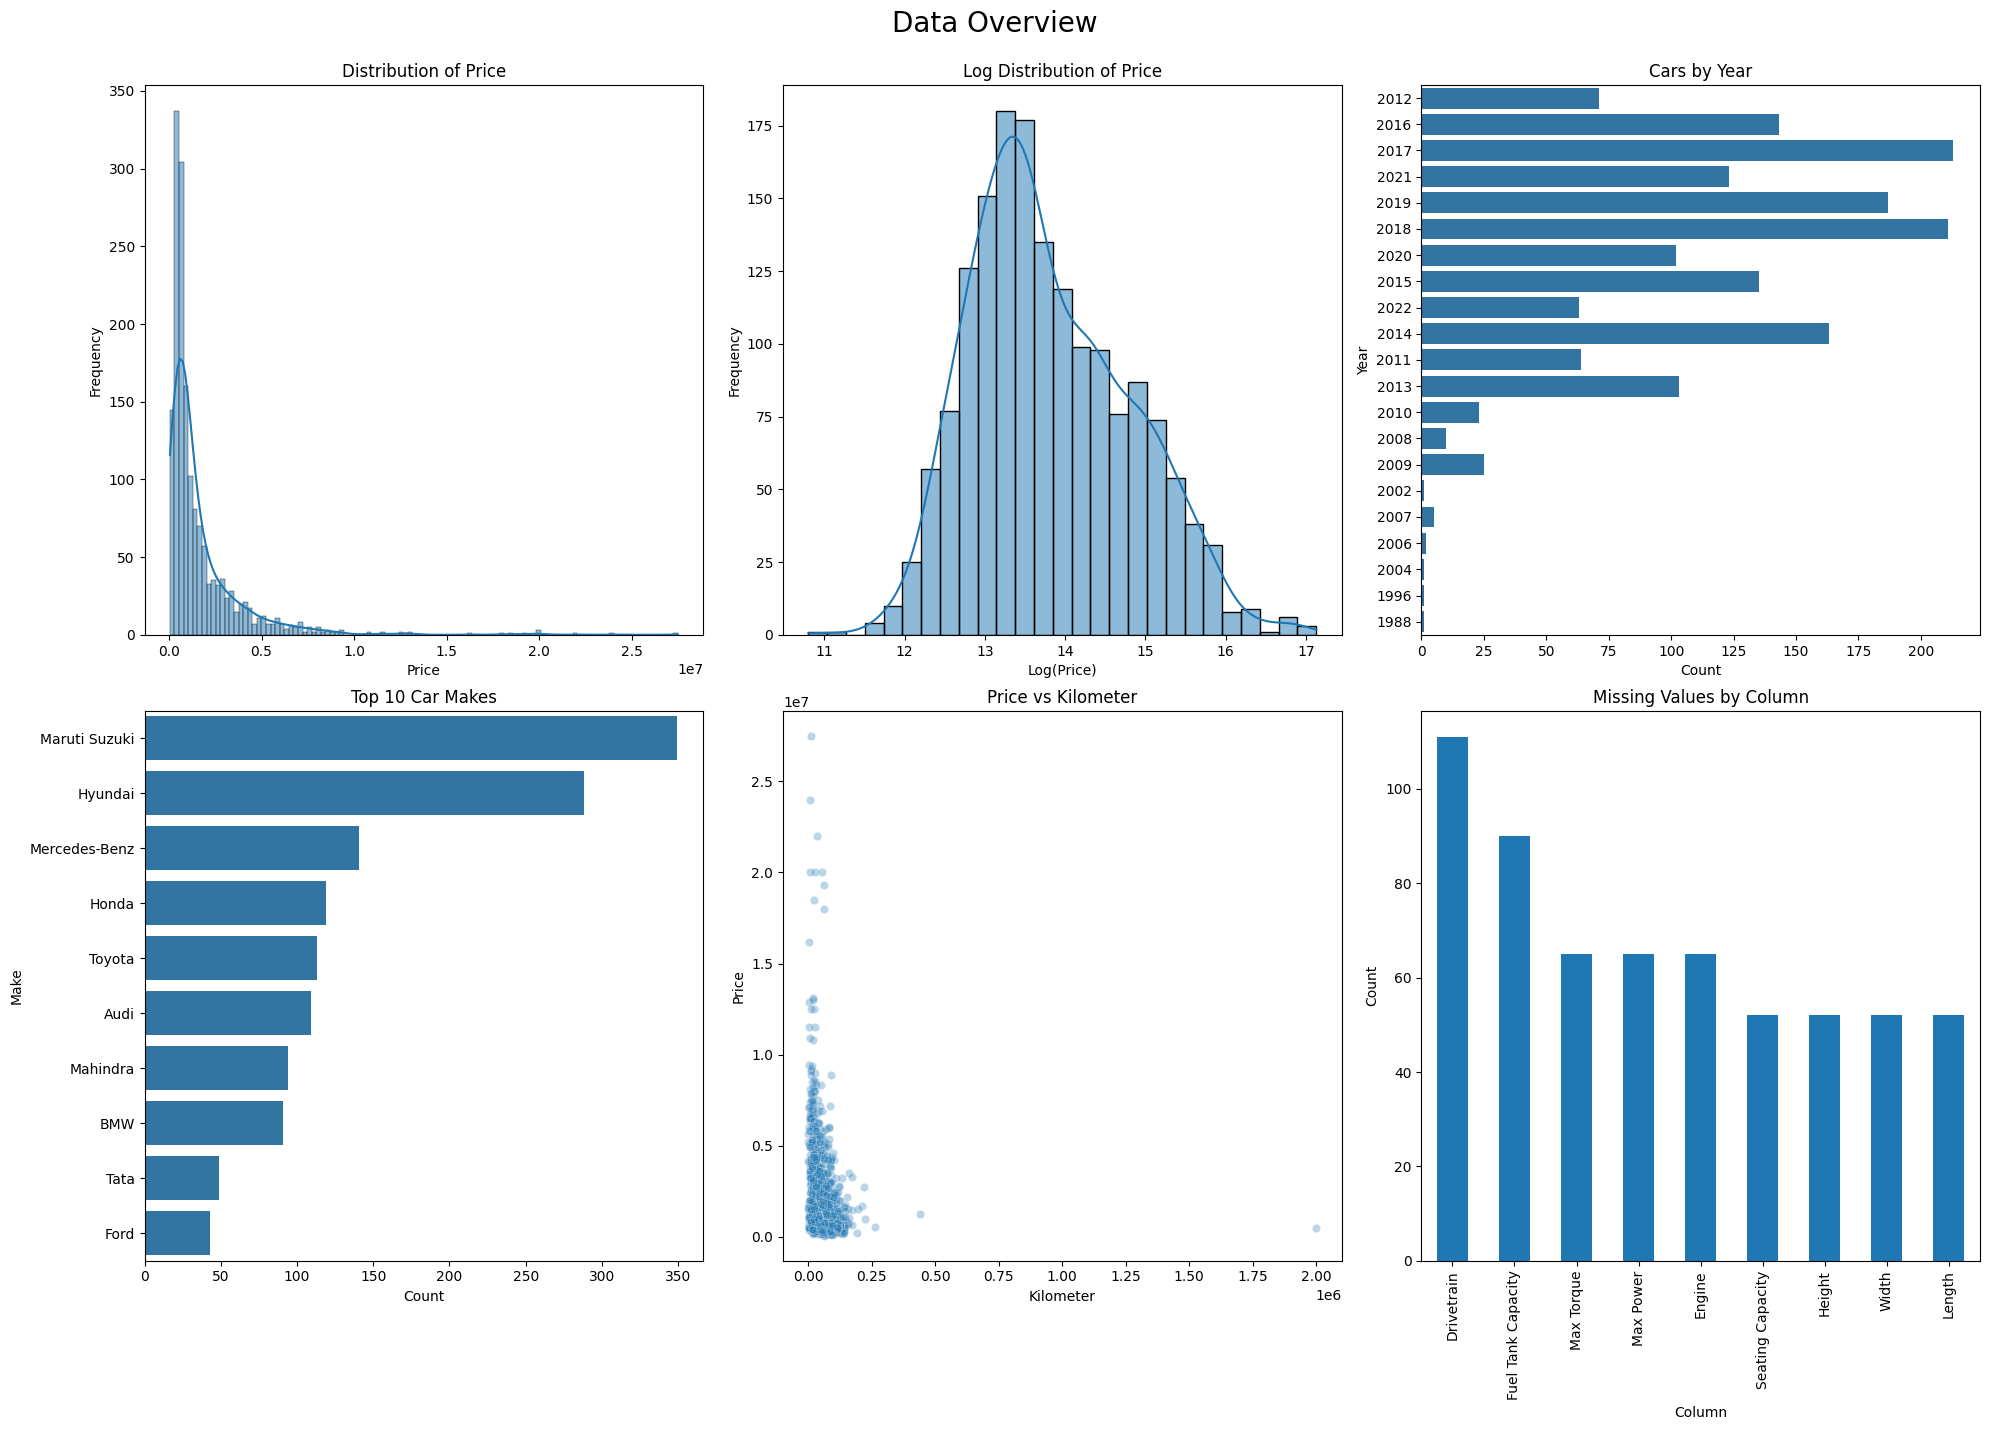

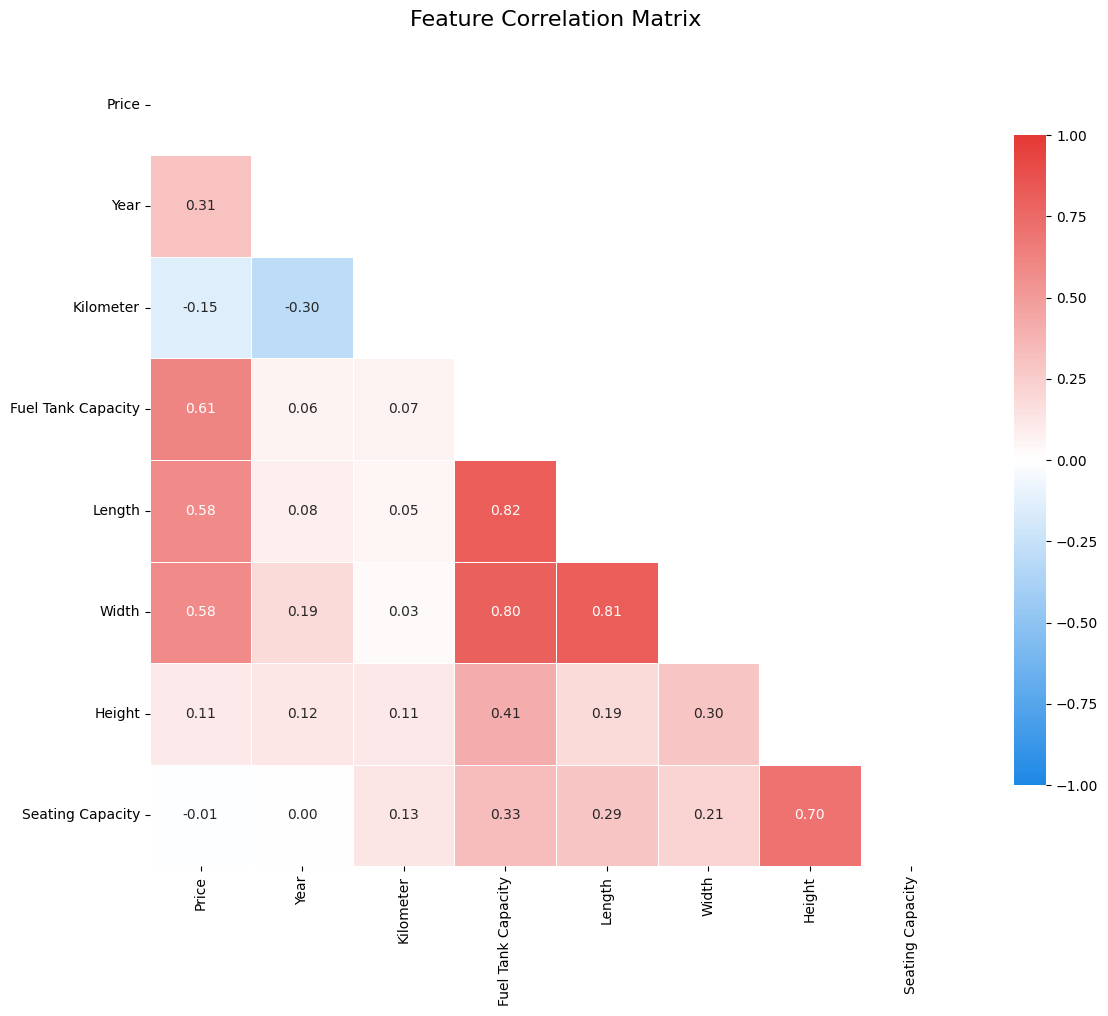

In [9]:
print("\n--- DATA ANALYSIS VISUALIZATIONS ---\n")
plot_data_overview(train_data, numeric_columns)
print("\n")
plot_correlation_matrix(train_data, numeric_columns)

# Tiền xử lý Dữ liệu


Trong phần này, dữ liệu sẽ được tiền xử lí qua các bước sau:
- Làm sạch dữ liệu.
- Xử lý các giá trị thiếu.
- Biến đổi dữ liệu nếu cần (ví dụ: biến đổi log của số km).
- Chuẩn hóa dữ liệu
- One-hot encoding
- Xử lí outliers
- Thêm các features mới (nâng cao bộ dữ liệu)

Cụ thể, em đã xây dựng hàm **"preprocess_data"** và các bước tiền xử lí theo thứ tự như sau:

In [10]:
def log_transform(X, feature_names=['Kilometer', 'Price']):
    for name in feature_names:
        if name in X.columns:
            X[name] = np.log1p(X[name])  # log1p handles zeros by adding 1 first
    return X

def one_hot_encode_df(df, categorical_columns):
    df_encoded = df.copy()
    for col in categorical_columns:
        if col in df_encoded.columns:
            dummies = pd.get_dummies(df_encoded[col], prefix=col, dummy_na=False, drop_first=True)
            dummies = dummies.astype(int)
            df_encoded = pd.concat([df_encoded, dummies], axis=1)
            df_encoded = df_encoded.drop(columns=[col])
    return df_encoded

def standardize_df(df, numeric_columns):
    df_standardized = df.copy()
    mean_std_dict = {}

    for col in numeric_columns:
        if col in df_standardized.columns:
            # Calculate mean and std, handling NaN values
            mean = df_standardized[col].mean()
            std = df_standardized[col].std()

            # Avoid division by zero
            if std == 0 or pd.isna(std):
                std = 1

            # Standardize the column
            df_standardized[col] = (df_standardized[col] - mean) / std

            # Replace NaN with 0 after standardization
            df_standardized[col] = df_standardized[col].fillna(0)

            # Store mean and std
            mean_std_dict[col] = {'mean': mean, 'std': std}

    return df_standardized, mean_std_dict

def extract_numeric_values(df):
    df_new = df.copy()

    # Engine: Extract number before "cc"
    if 'Engine' in df_new.columns:
        df_new['Engine_cc'] = df_new['Engine'].apply(
            lambda x: float(re.search(r'(\d+)', str(x)).group(1))
            if pd.notnull(x) and re.search(r'(\d+)', str(x)) else np.nan
        )

    # Max Power: Extract number before "bhp"
    if 'Max Power' in df_new.columns:
        df_new['Power_bhp'] = df_new['Max Power'].apply(
            lambda x: float(re.search(r'(\d+(?:\.\d+)?)', str(x)).group(1))
            if pd.notnull(x) and re.search(r'(\d+(?:\.\d+)?)', str(x)) else np.nan
        )

    # Max Torque: Extract number before "Nm"
    if 'Max Torque' in df_new.columns:
        df_new['Torque_Nm'] = df_new['Max Torque'].apply(
            lambda x: float(re.search(r'(\d+(?:\.\d+)?)', str(x)).group(1))
            if pd.notnull(x) and re.search(r'(\d+(?:\.\d+)?)', str(x)) else np.nan
        )

    # Remove original text columns
    df_new.drop(columns=['Engine', 'Max Power', 'Max Torque'], inplace=True, errors='ignore')

    return df_new

def fill_missing_values(df, group_cols=['Make', 'Model']):
    df_filled = df.copy()

    # Check missing values before imputation
    missing_before = df_filled.isnull().sum().sum()

    # First try: Group by Make and Model
    for col in df_filled.columns:
        if col in group_cols:
            continue

        if pd.api.types.is_numeric_dtype(df_filled[col]):
            # Fill numeric with median by group
            df_filled[col] = df_filled.groupby(group_cols)[col].transform(
                lambda x: x.fillna(x.median())
            )
        else:
            # Fill categorical with mode by group
            df_filled[col] = df_filled.groupby(group_cols)[col].transform(
                lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Unknown")
            )

    # Second try: Group by Make only for still missing values
    for col in df_filled.columns:
        if col in group_cols or col == group_cols[0]:
            continue

        if pd.api.types.is_numeric_dtype(df_filled[col]):
            # Fill numeric with median by Make
            df_filled[col] = df_filled.groupby(group_cols[0])[col].transform(
                lambda x: x.fillna(x.median())
            )
        else:
            # Fill categorical with mode by Make
            df_filled[col] = df_filled.groupby(group_cols[0])[col].transform(
                lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Unknown")
            )

    # Final fallback: Use global statistics for any remaining missing values
    for col in df_filled.columns:
        if pd.api.types.is_numeric_dtype(df_filled[col]):
            df_filled[col] = df_filled[col].fillna(df_filled[col].median())
        else:
            df_filled[col] = df_filled[col].fillna(df_filled[col].mode().iloc[0] if not df_filled[col].mode().empty else "Unknown")

    # Check missing values after imputation
    missing_after = df_filled.isnull().sum().sum()
    print(f" Missing values before: {missing_before}, after: {missing_after}")

    return df_filled

def enhance_features(df):
    df_enhanced = df.copy()

    # Current year based on data context (more reliable than system date)
    reference_year = max(df['Year']) + 1

    if 'Year' in df_enhanced.columns:
        df_enhanced['Car_Age'] = reference_year - df_enhanced['Year']

        # Log transformation for kilometer (handle skewed distribution)
        df_enhanced['Log_Kilometer'] = np.log1p(df_enhanced['Kilometer'])

        # Interaction terms for age and kilometers
        df_enhanced['Age_Km_Interaction'] = df_enhanced['Car_Age'] * df_enhanced['Kilometer'] / 10000

    # Size and volume features
    if all(col in df_enhanced.columns for col in ['Length', 'Width', 'Height']):
        # Calculate car volume (cubic meters for better scaling)
        df_enhanced['Volume_m3'] = (df_enhanced['Length'] * df_enhanced['Width'] * df_enhanced['Height']) / 1000000000

        # Weight to power ratio approximation (using volume as proxy for weight)
        if 'Power_bhp' in df_enhanced.columns:
            df_enhanced['Volume_Power_Ratio'] = df_enhanced['Volume_m3'] / (df_enhanced['Power_bhp'] + 1e-5)

    # Engine and power efficiency metrics
    if all(col in df_enhanced.columns for col in ['Engine_cc', 'Power_bhp']):
        # Power per liter (important performance indicator)
        df_enhanced['Power_per_Liter'] = 1000 * df_enhanced['Power_bhp'] / df_enhanced['Engine_cc']

    if all(col in df_enhanced.columns for col in ['Power_bhp', 'Torque_Nm']):
        # Power-to-torque ratio (indicates engine responsiveness)
        df_enhanced['Power_Torque_Ratio'] = df_enhanced['Power_bhp'] / (df_enhanced['Torque_Nm'] + 1e-5)

    # Depreciation-related features
    if all(col in df_enhanced.columns for col in ['Year', 'Price']):
        # Price per year of car age (depreciation indicator)
        df_enhanced['Price_per_Year'] = df_enhanced['Price'] / (reference_year - df_enhanced['Year'] + 1)

    # Market positioning features
    # Group premium vs economy brands
    premium_brands = ['BMW', 'Mercedes-Benz', 'Land Rover', 'Volvo', 'Audi', 'Lexus']
    if 'Make' in df_enhanced.columns:
        df_enhanced['Is_Premium'] = df_enhanced['Make'].apply(lambda x: 1 if x in premium_brands else 0)

    # Categorical encoding improvements for drivetrain
    if 'Drivetrain' in df_enhanced.columns:
        # Create drivetrain ranking (AWD > 4WD > RWD > FWD)
        drivetrain_rank = {'AWD': 3, '4WD': 2, 'RWD': 1, 'FWD': 0}
        df_enhanced['Drivetrain_Rank'] = df_enhanced['Drivetrain'].map(drivetrain_rank).fillna(0)

    return df_enhanced

def clip_outliers(X, feature_names=['Kilometer', 'Price']):
    for name in feature_names:
        if name in X.columns:
            Q1 = np.percentile(X[name], 25)
            Q3 = np.percentile(X[name], 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            X[name] = np.clip(X[name], lower_bound, upper_bound)
    return X

def handle_outliers(df, numeric_columns, target_col='Price'):

    df_cleaned = df.copy()

    # Define different IQR multipliers for different features
    iqr_multipliers = {
        'Price': 3.0,
        'Kilometer': 2.5,
        'Year': 1.5,
        'Power_bhp': 2.0,
        'Engine_cc': 2.0,
        'Car_Age': 1.5,
        'Price_per_Year': 3.0
    }

    # Use smaller multiplier for engineered features
    default_multiplier = 1.8

    outlier_stats = {}
    for col in numeric_columns:
        if col in df_cleaned.columns and col != target_col:  # Don't cap target variable
            # Get multiplier or use default
            multiplier = iqr_multipliers.get(col, default_multiplier)

            # Calculate IQR
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1

            # Define bounds with custom multiplier
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            # Count outliers before capping
            outliers_below = (df_cleaned[col] < lower_bound).sum()
            outliers_above = (df_cleaned[col] > upper_bound).sum()

            # Cap outliers
            df_cleaned[col] = df_cleaned[col].clip(lower_bound, upper_bound)

            # Store stats
            outlier_stats[col] = {
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outliers_below': outliers_below,
                'outliers_above': outliers_above
            }

    # Print summary of outlier handling
    print(" Outlier Handling Summary:")
    for col, stats in outlier_stats.items():
        if stats['outliers_below'] > 0 or stats['outliers_above'] > 0:
            print(f" - {col}: Capped {stats['outliers_below']} low outliers and {stats['outliers_above']} high outliers")

    return df_cleaned

def ensure_all_numeric(data_array):

    if isinstance(data_array, pd.DataFrame):
        # If it's a DataFrame, convert it to numpy array
        clean_data = data_array.copy()

        # First pass: Convert each column to numeric if possible
        for col in clean_data.columns:
            clean_data[col] = pd.to_numeric(clean_data[col], errors='coerce')

        # Replace any remaining NaN values with column means or 0
        for col in clean_data.columns:
            col_mean = clean_data[col].mean()
            if pd.isna(col_mean):
                col_mean = 0
            # Directly assign the result back to the column
            clean_data[col] = clean_data[col].fillna(col_mean)

        # Convert to numpy array
        numeric_array = clean_data.values

        # return DataFrame
        return pd.DataFrame(numeric_array, columns=clean_data.columns)
    else:
        # It's already a numpy array
        numeric_array = data_array.copy()

        # Check if it's object dtype and try to convert
        if numeric_array.dtype == 'object':
            # Try to convert the entire array to float
            try:
                numeric_array = numeric_array.astype(float)
            except (ValueError, TypeError):
                # If that fails, go element by element
                shape = numeric_array.shape
                numeric_array = np.zeros(shape, dtype=float)

                for i in range(shape[0]):
                    for j in range(shape[1]):
                        try:
                            numeric_array[i, j] = float(data_array[i, j])
                        except (ValueError, TypeError):
                            # If conversion fails, set to 0
                            numeric_array[i, j] = 0.0

        # Replace any NaN values with column means or 0
        for j in range(numeric_array.shape[1]):
            col_mean = np.nanmean(numeric_array[:, j])
            if np.isnan(col_mean):
                col_mean = 0
            mask = np.isnan(numeric_array[:, j])
            numeric_array[mask, j] = col_mean

        return numeric_array

def preprocess_data(df, numeric_columns, categorical_columns):

    print("Bắt đầu tiền xử lý dữ liệu...")

    # 0. Log transform year and kilometer
    print("\n Bước 0: Log transform hai cột 'Year' và 'Kilometer'")
    df = log_transform(df)

    # 1. Fill missing values
    print("\n Bước 1: Điền vào dữ liệu thiếu")
    df_filled = fill_missing_values(df, group_cols=['Make', 'Model'])

    # 2. Extract numeric values from text columns
    print("\n Bước 2: Trích xuất giá trị số từ các cột văn bản")
    df_extracted = extract_numeric_values(df_filled)

    # Add the newly created numeric columns to the list of numeric columns
    new_numeric_cols = ['Engine_cc', 'Power_bhp', 'Torque_Nm', 'Car_Age']
    numeric_columns = numeric_columns + [col for col in new_numeric_cols if col in df_extracted.columns]

    # 3. Feature engineering
    print("\n Bước 3: Tạo các đặc trưng mới")
    df_enhanced = enhance_features(df_extracted)

    # Update numeric columns with new engineered features
    engineered_numeric = [
        'Car_Age', 'Log_Kilometer', 'Age_Km_Interaction',
        'Volume_m3', 'Volume_Power_Ratio', 'Power_per_Liter',
        'Power_Torque_Ratio', 'Price_per_Year', 'Drivetrain_Rank'
    ]
    numeric_columns = numeric_columns + [col for col in engineered_numeric if col in df_enhanced.columns]

    # 4. Handle outliers in numeric columns
    print("\n Bước 4: Xử lý outliers")
    df_cleaned = clip_outliers(df_enhanced, numeric_columns)
    df_cleaned = handle_outliers(df_cleaned, numeric_columns)

    # 5. One-hot encoding for categorical features
    print("\n Bước 5: Mã hóa one-hot cho các cột phân loại")
    df_encoded = one_hot_encode_df(df_cleaned, categorical_columns)

    # 6. Standardize numeric features
    print("\n Bước 6: Chuẩn hóa dữ liệu")
    df_standardized, mean_std_dict = standardize_df(df_encoded, numeric_columns)

    # 7. Ensure all columns' values are numeric
    print("\n Bước 7: Chuyển đổi tất cả các giá trị cột thành số")
    df_standardized = ensure_all_numeric(df_standardized)

    print("\nTiền xử lý dữ liệu hoàn tất!")
    return df_standardized, mean_std_dict, numeric_columns

In [11]:
preprocessed_data, mean_std_dict, numeric_columns = preprocess_data(train_data, numeric_columns, categorical_columns)

Bắt đầu tiền xử lý dữ liệu...

 Bước 0: Log transform hai cột 'Year' và 'Kilometer'

 Bước 1: Điền vào dữ liệu thiếu
 Missing values before: 604, after: 0

 Bước 2: Trích xuất giá trị số từ các cột văn bản

 Bước 3: Tạo các đặc trưng mới

 Bước 4: Xử lý outliers
 Outlier Handling Summary:
 - Engine_cc: Capped 0 low outliers and 13 high outliers
 - Power_bhp: Capped 0 low outliers and 18 high outliers
 - Torque_Nm: Capped 0 low outliers and 3 high outliers
 - Volume_Power_Ratio: Capped 0 low outliers and 7 high outliers
 - Power_per_Liter: Capped 6 low outliers and 54 high outliers

 Bước 5: Mã hóa one-hot cho các cột phân loại

 Bước 6: Chuẩn hóa dữ liệu

 Bước 7: Chuyển đổi tất cả các giá trị cột thành số

Tiền xử lý dữ liệu hoàn tất!


In [12]:
print("Dữ liệu sau khi tiền xử lí:\n")
print("Số cột trong tập dữ liệu: ", preprocessed_data.shape[1])
print("Số dòng trong tập dữ liệu: ", preprocessed_data.shape[0])

Dữ liệu sau khi tiền xử lí:

Số cột trong tập dữ liệu:  1071
Số dòng trong tập dữ liệu:  1647


# Lựa chọn Đặc trưng


Ở đây, các cột dùng để huấn luyện sẽ được chọn ra bằng cách:
- Phân tích mối tương quan giữa các đặc trưng với biến mục tiêu (Coefficient Correlation).
- Kiểm tra chỉ số VIF (Variance Inflation Factor).


In [13]:
def calculate_vif(X, feature_names):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_names
    vif_data["VIF"] = [
        1 / (1 - r2_score(X[:, i],
                          X[:, np.arange(X.shape[1]) != i].dot(
                              np.linalg.lstsq(X[:, np.arange(X.shape[1]) != i],
                                              X[:, i], rcond=None)[0]
                          )
                         ))
        for i in range(X.shape[1])
    ]
    return vif_data.sort_values("VIF", ascending=False)

def select_features(df, target, min_corr=0.05, top_n=None, max_vif=10, iterative_vif=True):

    # Check if target exists
    if target not in df.columns:
        print(f"Warning: Cột '{target}' không được tìm thấy")
        return list(df.columns)

    # Handle missing values for the VIF calculation
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Get numeric columns excluding the target
    numeric_cols = df_clean.select_dtypes(include=['number']).columns.drop(target, errors='ignore')

    # Calculate absolute correlations with the target
    correlations = df_clean[numeric_cols].corrwith(df_clean[target]).abs().sort_values(ascending=False)

    # Essential car features that should always be included
    essential_features = ['Year', 'Kilometer', 'Engine_cc', 'Power_bhp', 'Car_Age']
    essential_features = [f for f in essential_features if f in df_clean.columns]

    # Filter by correlation threshold and stored its correlations
    min_corr = abs(min_corr)
    corr_selected = correlations[correlations >= min_corr].index.tolist()

    # Combine correlation-based selection with essential features
    initial_selected = list(set(corr_selected + essential_features))

    # Apply VIF-based filtering if we have enough features
    final_selected = initial_selected.copy()
    if len(initial_selected) > 1:
        try:
            if iterative_vif:
                # Iterative approach: remove one feature at a time
                current_features = initial_selected.copy()

                while True:
                    # Calculate VIF
                    vif_data = calculate_vif(df_clean[current_features].values, current_features)

                    # Find highest VIF non-essential feature
                    non_essential_vif = vif_data[~vif_data['Feature'].isin(essential_features)]

                    # Exit if no more non-essential features or all VIFs are acceptable
                    if non_essential_vif.empty or non_essential_vif['VIF'].max() <= max_vif:
                        break

                    # Remove the non-essential feature with highest VIF
                    max_vif_feature = non_essential_vif.iloc[0]['Feature']
                    max_vif_value = non_essential_vif.iloc[0]['VIF']

                    # Exit if we're down to just essential features plus one more
                    if len(current_features) <= len(essential_features) + 1:
                        break

                    # Remove the feature
                    current_features.remove(max_vif_feature)
                    print(f"Loại {max_vif_feature} vì VIF cao: {max_vif_value:.2f}")

                final_selected = current_features
            else:
                # One-shot approach: remove all high VIF features at once
                vif_data = calculate_vif(X, initial_selected)

                # Keep features with VIF below threshold and essential features
                low_vif_features = vif_data[vif_data['VIF'] <= max_vif]['Feature'].tolist()
                final_selected = list(set(low_vif_features + essential_features))

        except Exception as e:
            print(f"Tính VIF thất bại: {str(e)}. Sử dụng chỉ số tương quan")

    # Take top N if specified, always including essential features first
    if top_n is not None and len(final_selected) > top_n:
        # Sort remaining features by correlation
        non_essential = [f for f in final_selected if f not in essential_features]
        non_essential_sorted = sorted(
            non_essential,
            key=lambda x: correlations.get(x, 0),
            reverse=True
        )

        # Keep all essential features, plus top non-essential features up to top_n total
        remaining_slots = max(0, top_n - len(essential_features))
        final_selected = essential_features + non_essential_sorted[:remaining_slots]

    # Sort features by correlation for better interpretability
    selected_with_corr = [(f, correlations.get(f, 0)) for f in final_selected]
    selected_sorted = [f for f, _ in sorted(selected_with_corr, key=lambda x: x[1], reverse=True)]

    # Print selected features with their correlations and VIF
    print(f"\nĐã lựa chọn {len(selected_sorted)} feature:")

    try:
        # Calculate final VIF values for the selected features
        final_vif = calculate_vif(df_clean[selected_sorted].values, selected_sorted)

        for feature in selected_sorted:
            if feature in essential_features:
                print(f" - {feature}: cần thiết")
            else:
                print(f" - {feature}: correlation = {correlations[feature]:.4f}, VIF = {final_vif[final_vif['Feature'] == feature]['VIF'].values[0]:.4f}")
    except:
        # Fall back to just correlations if VIF calculation fails
        for feature in selected_sorted:
            if feature in essential_features:
                print(f" - {feature}: cần thiết")
            else:
                print(f" - {feature}: correlation = {correlations[feature]:.4f}")

    return selected_sorted

In [14]:
selected_features = select_features(
    preprocessed_data,
    'Price',
    min_corr=0.3,
    top_n=20,
    max_vif=5,
    iterative_vif=True
)

Loại Log_Kilometer vì VIF cao: 1362.83
Loại Age_Km_Interaction vì VIF cao: 466.58
Loại Torque_Nm vì VIF cao: 32.49
Loại Power_per_Liter vì VIF cao: 17.62
Loại Volume_m3 vì VIF cao: 15.80
Loại Price_per_Year vì VIF cao: 7.30
Loại Power_Torque_Ratio vì VIF cao: 6.61
Loại Volume_Power_Ratio vì VIF cao: 6.45
Loại Length vì VIF cao: 5.96

Đã lựa chọn 17 feature:
 - Power_bhp: cần thiết
 - Width: correlation = 0.7791, VIF = 4.2796
 - Fuel Tank Capacity: correlation = 0.7359, VIF = 4.9681
 - Engine_cc: cần thiết
 - Transmission_Manual: correlation = 0.6591, VIF = 1.8430
 - Is_Premium: correlation = 0.6422, VIF = 3.4096
 - Drivetrain_Rank: correlation = 0.5979, VIF = 3.6367
 - Drivetrain_FWD: correlation = 0.5156, VIF = 3.7758
 - Car_Age: cần thiết
 - Year: cần thiết
 - Make_Maruti Suzuki: correlation = 0.3859, VIF = 1.3043
 - Make_Mercedes-Benz: correlation = 0.3792, VIF = 1.9855
 - Fuel Type_Diesel: correlation = 0.3648, VIF = 3.8612
 - Drivetrain_RWD: correlation = 0.3358, VIF = 2.0375
 - F

In [15]:
print(f"\nTên {len(selected_features)} feature đã chọn:")
for feature in selected_features:
    print(f' - {feature}')


Tên 17 feature đã chọn:
 - Power_bhp
 - Width
 - Fuel Tank Capacity
 - Engine_cc
 - Transmission_Manual
 - Is_Premium
 - Drivetrain_Rank
 - Drivetrain_FWD
 - Car_Age
 - Year
 - Make_Maruti Suzuki
 - Make_Mercedes-Benz
 - Fuel Type_Diesel
 - Drivetrain_RWD
 - Fuel Type_Petrol
 - Kilometer
 - Make_BMW


# Chia Dữ liệu


Chia dữ liệu thành tập huấn luyện và tập kiểm thử để đánh giá hiệu năng mô hình:
- **Training set:** Dùng để huấn luyện mô hình **(80%)**.
- **Validation/Test set:** Dùng để kiểm tra và đánh giá hiệu năng mô hình **(20%)**.

In [16]:
def train_val_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)

    test_samples = int(n_samples * test_size)
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    X_train = X[train_indices]
    X_val = X[test_indices]
    y_train = y[train_indices]
    y_val = y[test_indices]

    return X_train, X_val, y_train, y_val

In [17]:
print("Chia dữ liệu thành tập huấn luyện và tập kiểm thử...\n")

X = preprocessed_data[selected_features].values
y = preprocessed_data['Price'].values.reshape(-1, 1)

X_train, X_val, y_train, y_val = train_val_split(X, y, test_size=0.2, random_state=42)

print("Chia dữ liệu thành công!")

Chia dữ liệu thành tập huấn luyện và tập kiểm thử...

Chia dữ liệu thành công!


In [18]:
print(f"Kích thước tập huấn luyện: {X_train.shape[0]}")
print(f"Kích thước tập kiểm thử: {X_val.shape[0]}")

Kích thước tập huấn luyện: 1318
Kích thước tập kiểm thử: 329


# Mô hình Hồi quy

## Định nghĩa các công thức hồi quy sẽ sử dụng


1. **Hồi quy Tuyến tính Chuẩn**
$$Price = \beta_0 + \alpha_1 X_1 + \alpha_2 X_2 + ... + \alpha_n X_n + \varepsilon$$
- Trong đó:
  - $\beta_0$ là intercept
  - $\alpha_1, \alpha_2, ..., \alpha_n$ là hệ số của các features $X_1, X_2, ..., X_n$
  - $\varepsilon$ là sai số

- **Ridge (L2 Regularization)**:
$$min_{\alpha} \left( \sum_{i=1}^{m} (y_i - \alpha X_i)^2 + \lambda_2 \sum_{j=1}^{n} \alpha_j^2 \right)$$

2. **Hồi quy Logarithmic**
$$Price = \beta_0 + \alpha_1 \log(X_1) + \alpha_2 \log(X_2) + ... + \alpha_n \log(X_n) + \varepsilon$$

3. **Hồi quy Đa thức Bậc 2**
$$Price = \beta_0 + \alpha_1 X_1 + \alpha_2 X_2 + ... + \alpha_n X_n + \alpha_{n+1} X_1^2 + \alpha_{n+2} X_2^2 + ... + \alpha_{2n} X_n^2 + \varepsilon$$

4. **Hồi quy Tương tác Đặc trưng**
$$Price = \beta_0 + \alpha_1 X_1 + \alpha_2 X_2 + ... + \alpha_n X_n + \alpha_{n+1} (X_1 \times X_2) + \alpha_{n+2} (X_1 \times X_3) + ... + \varepsilon$$

In [451]:
class Regression:
    def __init__(self, lambda_l1=0.0, lambda_l2=0.0, feature_transformer=None, name="Hồi quy Tuyến Tính Chuẩn", degree=2):
        self.coefficients = None
        self.intercept = None
        self.lambda_l1 = lambda_l1  # L1 regularization
        self.lambda_l2 = lambda_l2  # L2 regularization
        self.feature_transformer = feature_transformer
        self.degree = degree  # for polynomial 
        self.name = name
        self.feature_names = None
        self.feature_importances_ = None

    def _transform_features(self, X, feature_names=None):
        if self.feature_transformer is None:
            return X, feature_names
                
        # If no feature names provided, use default names
        if feature_names is None:
            feature_names = [f"feature_{i}" for i in range(X.shape[1])]
        
        # Handle polynomial transformation
        if self.feature_transformer == polynomial_transformer:
            transformed_X = self.feature_transformer(X, self.degree)
            transformed_names = []
            
            # Add original features
            transformed_names.extend(feature_names)
            
            # Add polynomial features 
            for d in range(2, self.degree + 1): 
                for name in feature_names:
                    transformed_names.append(f"{name}^{d}")
                    
            return transformed_X, transformed_names
        
        # Handle logarithmic 
        elif self.feature_transformer == logarithmic_transformer:
            transformed_X = self.feature_transformer(X)
            transformed_names = [f"log({name})" for name in feature_names]
            return transformed_X, transformed_names
        
        # Handle feature interaction
        elif self.feature_transformer == interaction_transformer:
            transformed_X = self.feature_transformer(X)
            transformed_names = feature_names.copy()
            
            for i in range(len(feature_names)):
                for j in range(i+1, len(feature_names)):
                    transformed_names.append(f"{feature_names[i]}*{feature_names[j]}")
                    
            return transformed_X, transformed_names
        
        # Handle other transformers
        else:
            return self.feature_transformer(X), feature_names

    def fit(self, X, y, feature_names=None):
        
            X_transformed, self.feature_names = self._transform_features(X, feature_names)   
            print(X_transformed.shape)

            # Add intercept 
            X_with_intercept = np.column_stack(
                (np.ones(X_transformed.shape[0]), X_transformed))

            # L2 regularization
            n_samples, n_features = X_with_intercept.shape
            reg_matrix = self.lambda_l2 * np.eye(n_features)
            reg_matrix[0, 0] = 0  # not regularize intercept

            # using SVD for stability
            XTX = np.dot(X_with_intercept.T, X_with_intercept) + reg_matrix
            XTy = np.dot(X_with_intercept.T, y)

            try:
                theta = np.dot(np.linalg.inv(XTX), XTy)
            except np.linalg.LinAlgError:
                print(
                    f"Warning: Chuyen ma tran khong thanh cong. Su fung SVD cho {self.name}.")
                theta = np.dot(np.linalg.pinv(XTX), XTy)

            self.intercept = theta[0]
            self.coefficients = theta[1:]

            self.calculate_feature_importance()

            return self

    def predict(self, X):
        X_transformed, self.feature_names = self._transform_features(X, self.feature_names)
        return self.intercept + np.dot(X_transformed, self.coefficients)

    def get_feature_names(self):
        return self.feature_names

    def calculate_feature_importance(self):
        if self.coefficients is None:
            return None

        importance = np.abs(self.coefficients).flatten()

        if importance.max() > 0:
            importance = 100 * importance / importance.max()

        self.feature_importances_ = importance

        if self.feature_names is not None and len(importance) == len(self.feature_names):
            return dict(zip(self.feature_names, importance))
        else:
            return None

    def get_feature_importance(self, top_n=10):
        if self.feature_importances_ is None or self.feature_names is None:
            return None

        if top_n > 0:
          top_n = min(len(self.feature_names), top_n)
          return dict(zip(self.feature_names[:top_n], self.feature_importances_[:top_n]))
        else:
          return dict(zip(self.feature_names, self.feature_importances_))

    def plot_feature_importance(self, top_n=10):
        if self.feature_importances_ is None or self.feature_names is None:
            return None

        top_n = min(len(self.feature_names), top_n)

        tmp = self.get_feature_importance(top_n)
        feature_names = list(tmp.keys())
        importance = list(tmp.values())

        feat_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })

        # Sort by importance and take top_n
        feat_importance = feat_importance.sort_values('Importance', ascending=False).head(top_n)

        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')
        plt.title(f'Top {top_n} Importance Features', fontsize=16)
        plt.xlabel('Absolute Coefficient Value', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()

        return None

# Polynomial transformer
def polynomial_transformer(X, degree=2):
    X_poly = []
    for x in X.T:
        for d in range(2, degree+1):
            x_poly = np.power(x, d).reshape(-1, 1)
            X_poly.append(x_poly)
    res = np.hstack(X_poly)
    return np.hstack([X, res])

# Interaction transformer
def interaction_transformer(X):
    _, n_features = X.shape

    interactions = [X]

    for i in range(n_features):
        for j in range(i+1, n_features):
            interaction = (X[:, i] * X[:, j]).reshape(-1, 1)
            interactions.append(interaction)

    return np.hstack(interactions)

# Log transformer
def logarithmic_transformer(X, epsilon=1e-10):
    X_positive = np.maximum(X, epsilon)
    return np.hstack([X, np.log(X_positive)])

## Khởi tạo các mô hình hồi quy

Sử dụng các mô hình với tham số L1, L2 có thể điều chỉnh được

In [ ]:
def create_models():
    models = []

    # Standard
    models.append(Regression(
        lambda_l1=0.0,
        lambda_l2=0.0,
        name="Hồi quy Tuyến tính Chuẩn"
    ))

    # Logarithmic features
    models.append(Regression(
        lambda_l2=1.5,
        feature_transformer=logarithmic_transformer,
        name="Hồi quy Logarit"
    ))

    # Squared features
    models.append(Regression(
        lambda_l2=1.5,
        feature_transformer=polynomial_transformer,
        name="Hồi quy Đa thức Bậc 2",
        degree=2
    ))

    # Interaction features
    models.append(Regression(
        lambda_l2=1.6,
        feature_transformer=interaction_transformer,
        name="Hồi quy Tương tác Đặc trưng"
    ))

    return models

In [453]:
print("Đang khởi tạo các mô hình Hồi quy...\n")
models = create_models()
print(f"Đã khởi tạo {len(models)} mô hình:")
for model in models:
    print(f" - {model.name}")

Đang khởi tạo các mô hình Hồi quy...

Đã khởi tạo 4 mô hình:
 - Hồi quy Tuyến tính Chuẩn
 - Hồi quy Logarit
 - Hồi quy Đa thức Bậc 2
 - Hồi quy Tương tác Đặc trưng


# Cross-Validation


Áp dụng k-fold cross-validation để đảm bảo tính ổn định và tổng quát của mô hình:
- Phân chia dữ liệu thành k phần.
- Huấn luyện và đánh giá mô hình trên từng phần.

In [454]:
def cross_validate(models, X, y, feature_names=None, k_folds=5, random_state=42, max_iter=1000, tol=1e-6, learning_rate=0.01, patience=10):
    n_samples = X.shape[0]
    fold_size = n_samples // k_folds

    # Initialize results storage
    results = {model.name: {
        'mse': [], 'rmse': [], 'mae': [], 'r2': [],
        'fold_predictions': [], 'fold_actuals': [],
        'iterations': []
    } for model in models}

    # Create random indices
    np.random.seed(random_state)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    print(f"\nTiến hành cross-validation với {k_folds} folds...")
    for i in range(k_folds):
        print(f" Fold {i+1}/{k_folds}:")

        # Create validation set
        val_indices = indices[i * fold_size:(i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train_fold, X_val_fold = X[train_indices], X[val_indices]
        y_train_fold, y_val_fold = y[train_indices], y[val_indices]

        # Train and evaluate each model
        for model in models:
            print(f"  - Huấn luyện mô hình {model.name} ...")

            model.fit(X_train_fold, y_train_fold, feature_names)

            # Store iteration
            results[model.name]['iterations'].append(0)

            # Generate predictions
            y_pred = model.predict(X_val_fold)

            # Calculate metrics
            losses = calculate_losses(y_val_fold, y_pred)
            mse, rmse, mae, r2 = losses['MSE'], losses['RMSE'], losses['MAE'], losses['R2']

            # Store results
            results[model.name]['mse'].append(mse)
            results[model.name]['rmse'].append(rmse)
            results[model.name]['mae'].append(mae)
            results[model.name]['r2'].append(r2)
            results[model.name]['fold_predictions'].append(y_pred)
            results[model.name]['fold_actuals'].append(y_val_fold)

    # Calculate and return average performance
    summary = {}
    for model_name, metrics in results.items():
        summary[model_name] = {
            'avg_mse': np.mean(metrics['mse']),
            'avg_rmse': np.mean(metrics['rmse']),
            'avg_mae': np.mean(metrics['mae']),
            'avg_r2': np.mean(metrics['r2']),
            'std_mse': np.std(metrics['mse']),
            'std_r2': np.std(metrics['r2']),
            'all_mse': metrics['mse'],
            'all_r2': metrics['r2'],
            'avg_iterations': np.mean(metrics['iterations']) if metrics['iterations'] else "analytical",
            'fold_actuals': metrics['fold_actuals'],
            'fold_predictions': metrics['fold_predictions']
        }

    return summary

In [455]:
cv_results = cross_validate(models, X_train, y_train, selected_features, k_folds=5, random_state=42, max_iter=1000, tol=1e-6, learning_rate=0.01, patience=10)


Tiến hành cross-validation với 5 folds...
 Fold 1/5:
  - Huấn luyện mô hình Hồi quy Tuyến tính Chuẩn ...
(1055, 17)
  - Huấn luyện mô hình Hồi quy Logarit ...
(1055, 34)
  - Huấn luyện mô hình Hồi quy Đa thức Bậc 2 ...
(1055, 51)
  - Huấn luyện mô hình Hồi quy Tương tác Đặc trưng ...
(1055, 153)
 Fold 2/5:
  - Huấn luyện mô hình Hồi quy Tuyến tính Chuẩn ...
(1055, 17)
  - Huấn luyện mô hình Hồi quy Logarit ...
(1055, 34)
  - Huấn luyện mô hình Hồi quy Đa thức Bậc 2 ...
(1055, 51)
  - Huấn luyện mô hình Hồi quy Tương tác Đặc trưng ...
(1055, 153)
 Fold 3/5:
  - Huấn luyện mô hình Hồi quy Tuyến tính Chuẩn ...
(1055, 17)
  - Huấn luyện mô hình Hồi quy Logarit ...
(1055, 34)
  - Huấn luyện mô hình Hồi quy Đa thức Bậc 2 ...
(1055, 51)
  - Huấn luyện mô hình Hồi quy Tương tác Đặc trưng ...
(1055, 153)
 Fold 4/5:
  - Huấn luyện mô hình Hồi quy Tuyến tính Chuẩn ...
(1055, 17)
  - Huấn luyện mô hình Hồi quy Logarit ...
(1055, 34)
  - Huấn luyện mô hình Hồi quy Đa thức Bậc 2 ...
(1055, 51)
  - 

In [456]:
print("Kết quả của Cross-Validation:")
for model_name, metrics in cv_results.items():
    print(f" {model_name}:")
    print(f"  - Average MSE: {metrics['avg_mse']:.4f}")
    print(f"  - Average MAE: {metrics['avg_mae']:.4f}")
    print(f"  - Average R²: {metrics['avg_r2']:.4f}")

Kết quả của Cross-Validation:
 Hồi quy Tuyến tính Chuẩn:
  - Average MSE: 0.1184
  - Average MAE: 0.2479
  - Average R²: 0.8826
 Hồi quy Logarit:
  - Average MSE: 0.0892
  - Average MAE: 0.2123
  - Average R²: 0.9111
 Hồi quy Đa thức Bậc 2:
  - Average MSE: 0.0874
  - Average MAE: 0.2093
  - Average R²: 0.9129
 Hồi quy Tương tác Đặc trưng:
  - Average MSE: 0.0674
  - Average MAE: 0.1839
  - Average R²: 0.9330



--- CROSS-VALIDATION RESULTS VISUALIZATION ---



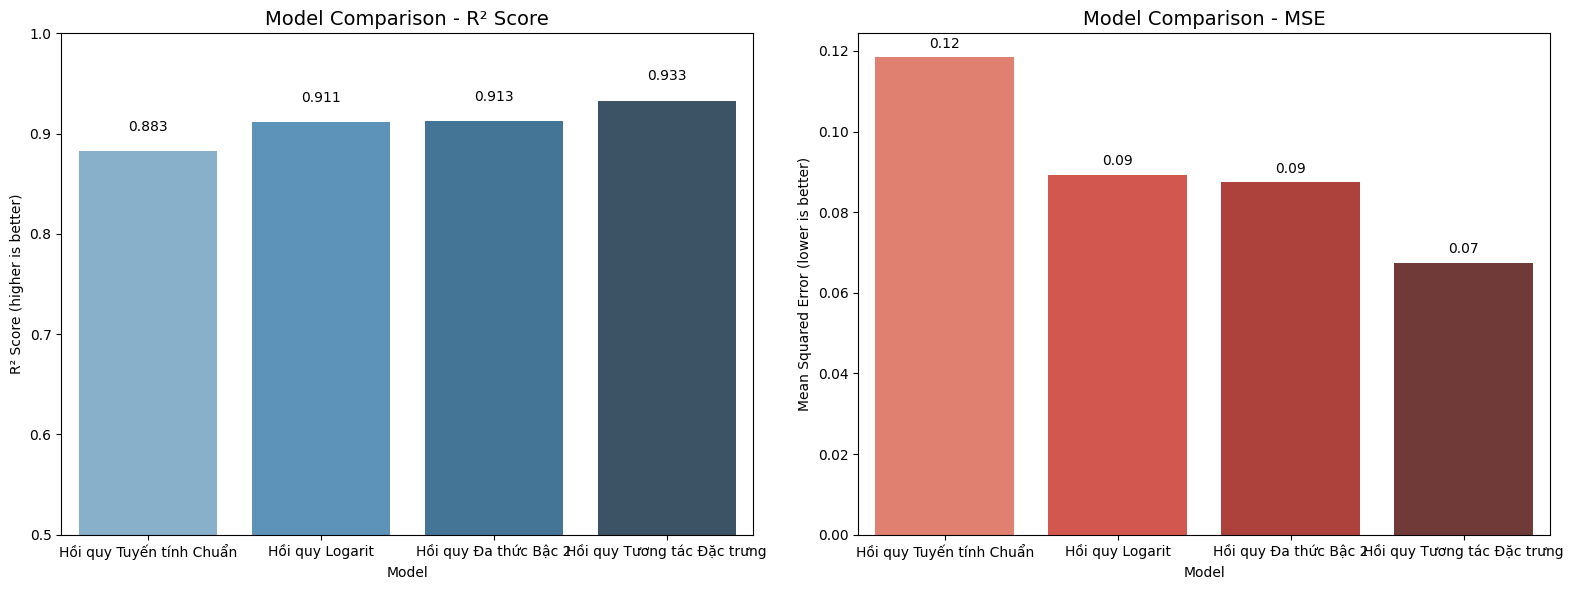

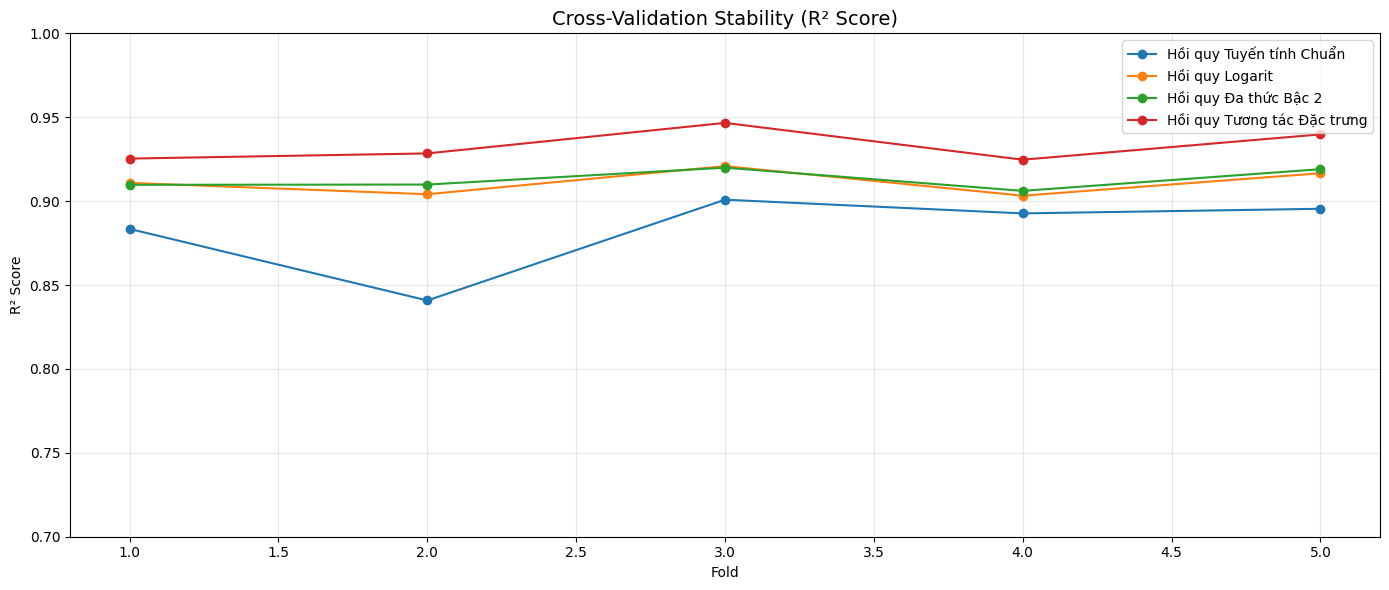

In [457]:
print("\n--- CROSS-VALIDATION RESULTS VISUALIZATION ---\n")
plot_model_comparison(cv_results)

# Đánh giá và Lựa chọn Mô hình tốt nhất


Đánh giá các mô hình dựa trên các chỉ số sau:
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**
- **Mean Absolute Error (MAE)**
- **R² Score (Hệ số xác định)**

Sau đó, chọn mô hình có hiệu năng tốt nhất dựa trên **R² Score**.


In [458]:
def select_best_model(cv_results, metric='avg_r2', higher_is_better=True):
    if higher_is_better:
        best_score = -np.inf
        best_model_name = None
        for model_name, metrics in cv_results.items():
            if metrics[metric] > best_score:
                best_score = metrics[metric]
                best_model_name = model_name
    else:
        best_score = np.inf
        best_model_name = None
        for model_name, metrics in cv_results.items():
            if metrics[metric] < best_score:
                best_score = metrics[metric]
                best_model_name = model_name

    print(f"Mô hình tốt nhất dựa trên {metric} là mô hình {best_model_name} với số điểm {best_score:.4f}")
    return best_model_name

In [459]:
best_model_name = select_best_model(cv_results, metric='avg_r2', higher_is_better=True)

best_model = None
for model in models:
    if model.name == best_model_name:
        best_model = model
        break

Mô hình tốt nhất dựa trên avg_r2 là mô hình Hồi quy Tương tác Đặc trưng với số điểm 0.9330


# Huấn luyện thêm trên Mô hình tốt nhất

Huấn luyện mô hình tốt nhất trên toàn bộ tập Train

In [460]:
if best_model:
  print(f"Huấn luyện mô hình {best_model.name} trên toàn bộ tập Train...\n")
  best_model.fit(X_train, y_train, selected_features)
  print(f"Mô hình {best_model.name} đã huấn luyện hoàn tất!")

Huấn luyện mô hình Hồi quy Tương tác Đặc trưng trên toàn bộ tập Train...

(1318, 153)
Mô hình Hồi quy Tương tác Đặc trưng đã huấn luyện hoàn tất!


Sau đó, đánh giá mô hình vừa được huấn luyện trên tập Val (tập hoàn toàn mới)

In [461]:
y_pred = best_model.predict(X_val)
losses = calculate_losses(y_val, y_pred)
mse, rmse, mae, r2 = losses['MSE'], losses['RMSE'], losses['MAE'], losses['R2']

print(f'Đánh giá mô hình {best_model.name} trên tập Val:')
print(f" - MSE: {mse:.4f}")
print(f" - RMSE: {rmse:.4f}")
print(f" - MAE: {mae:.4f}")
print(f" - R²: {r2:.4f}")

Đánh giá mô hình Hồi quy Tương tác Đặc trưng trên tập Val:
 - MSE: 0.0510
 - RMSE: 0.2257
 - MAE: 0.1645
 - R²: 0.9480



--- BEST MODEL PERFORMANCE VISUALIZATION ---



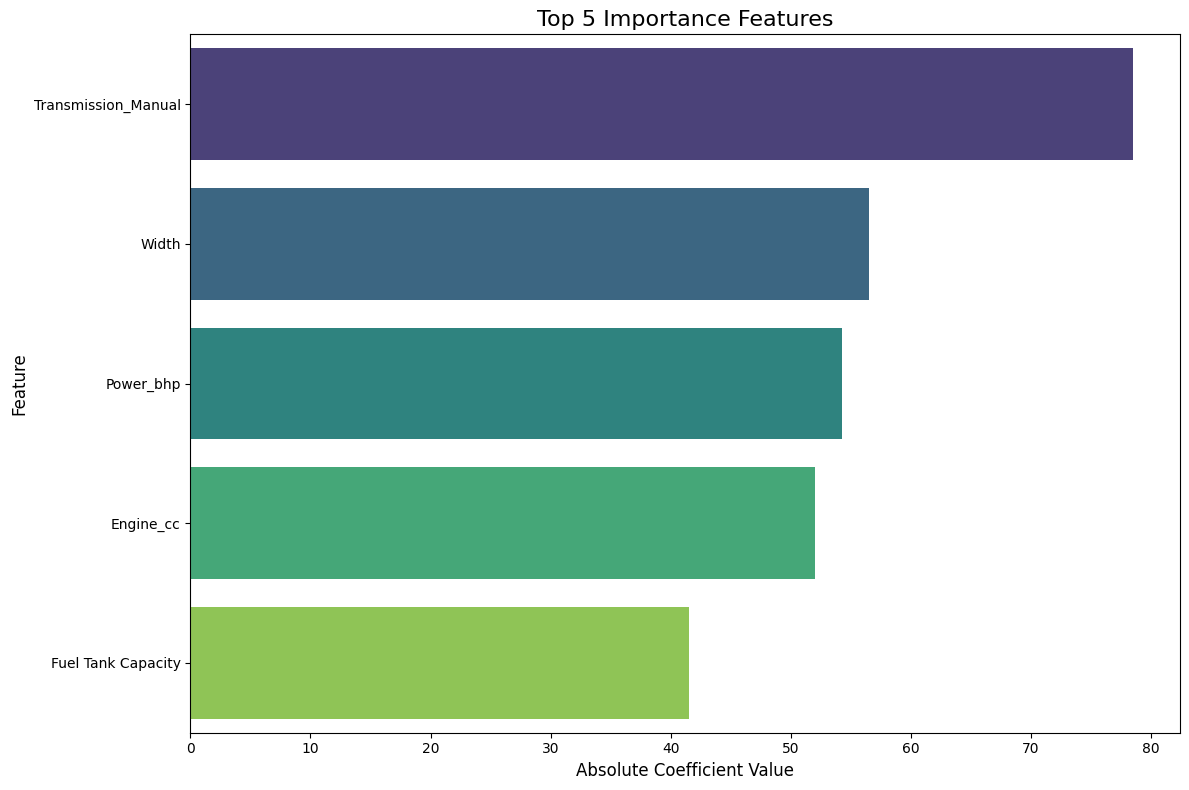

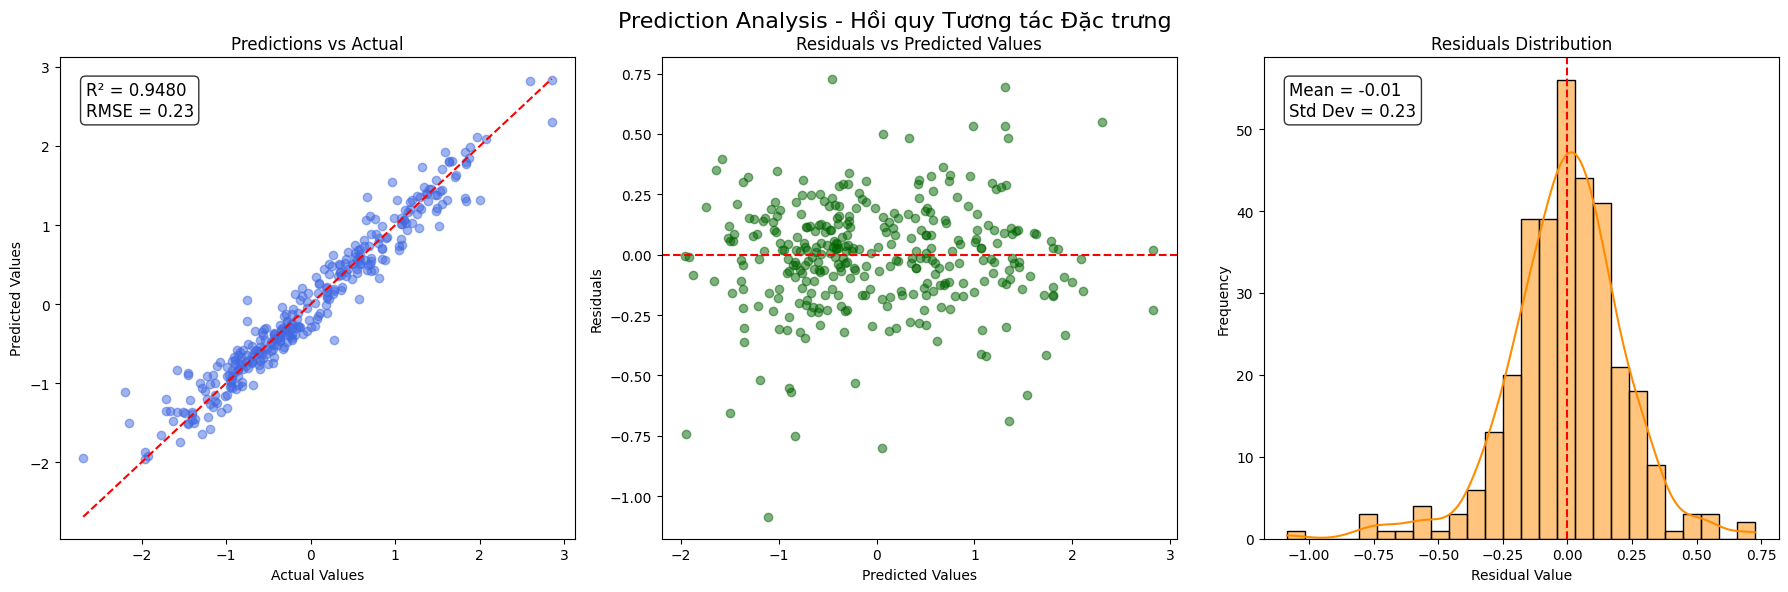

In [462]:
print(f"\n--- BEST MODEL PERFORMANCE VISUALIZATION ---\n")
best_model.plot_feature_importance(top_n=5)
print("\n")
plot_prediction_analysis(y_val, y_pred, best_model.name)

# Test

Xây dựng hàm để có thể:
- Cho người dùng nhập tên của dữ liệu
- Đọc file dữ liệu và xử lí
- In ra kết quả của mô hình cho dữ liệu

In [463]:
def evaluate_on_test(test_file_path, model):
    try:
        # Load test data
        print("1. Load dữ liệu ...")
        if test_file_path.endswith('.xlsx'):
            test_data = pd.read_excel(test_file_path)
        elif test_file_path.endswith('.csv'):
            test_data = pd.read_csv(test_file_path)

        # Apply preprocessing pipeline
        print("\n2. Tiền xử lý dữ liệu...")
        test_data_processed, _, _ = preprocess_data(test_data, numeric_columns, categorical_columns)

        # Get features to predict
        print("\n3. Lấy đặc trưng để dự đoán...")
        selected_features = best_model.get_feature_names()
        print("  Các đặc trưng được chọn:")
        for feature in selected_features:
            print(f"  - {feature}")

        # Prepare test data
        print("\n4. Chuẩn bị dữ liệu test...")
        X_test = test_data_processed[selected_features].values
        y_test = test_data_processed['Price'].values.reshape(-1, 1)
        print(f'Dữ liệu test được chuẩn bị có {X_test.shape[0]} dòng và {X_test.shape[1]} cột')

        # predict
        print("\n5. Dự đoán trên dữ liệu test và tính sai số...")
        y_pred = model.predict(X_test)
        losses = calculate_losses(y_test, y_pred)
        mse, rmse, mae, r2 = losses['MSE'], losses['RMSE'], losses['MAE'], losses['R2']

        print("\n6. Đánh giá trên tập test:")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R²: {r2:.4f}\n")

        # Plot prediction analysis
        print("\n--- TEST SET PERFORMANCE VISUALIZATION ---\n")
        plot_prediction_analysis(y_test, y_pred, model.name)

    except Exception as e:
        print(f'Lỗi khi tải hoặc xử lý dữ liệu test: {e}')
        return None

In [464]:
# print("Nhập đường dẫn đến tập dữ liệu kiểm tra:")
# test_file_path = input()

In [465]:
# test_data_processed = evaluate_on_test(test_file_path, best_model)